# Improvise a Jazz Solo with an LSTM Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Deep Learning Projects/Music-Generation-With-LSTM-Network')

## Packages

In [3]:
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.8 MB/s eta 0:00:00


In [4]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install music21==6.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941699 sha256=283601c84f39eaf2a9dda718c32353b718337c6dbdcb96b29ceee6588f846aa2
  Stored in directory: /root/.cache/pip/wheels/ee/85/7c/df0bc93fb2e51364c39cb3433e644156196bd74a1089604a57
Successfully built music21
  Attempting uninstall: music21
    Found existing installation: music21 8.1.0
    Uninstalling music21-8.1.0:
      Successfully uninstalled music21-8.1.0


In [6]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from music21 import *
from grammar import *
from qa import *
from preprocess import *
from music_utils import *
from data_utils import *
from outputs import *
from test_utils import *

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## Dataset

In [7]:
X, Y, n_values, indices_values, chords = load_music_utils('data/original_metheny.mid')
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 90
shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


## Building the Model

In [8]:
n_a = 64 # number of dimensions for the hidden state of each LSTM cell.
n_values = 90 # number of music values
reshaper = Reshape((1, n_values))
LSTM_cell = LSTM(n_a, return_state = True)
densor = Dense(n_values, activation='softmax')

In [9]:
def djmodel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the djmodel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema:
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance

    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    n_values = densor.units
    n_a = LSTM_cell.units
    X = Input(shape=(Tx, n_values))
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    outputs = []
    for t in range(Tx):
      x = X[:,t,:]
      x = reshaper(x)
      _, a, c = LSTM_cell(inputs=x, initial_state=[a, c])
      out = densor(a)
      outputs.append(out)
    model = Model(inputs=[X, a0, c0], outputs=outputs)

    return model

In [10]:
model = djmodel(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 90)]     0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 90)          0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 reshape (Reshape)              (None, 1, 90)        0           ['tf.__operators__.getitem[0][0]'
                                                                 , 'tf.__operators__.getitem_1[0][
                                                                 0]',                         

In [14]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, weight_decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [15]:
history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

loss at epoch 1: 129.97055053710938
loss at epoch 100: 7.241441249847412


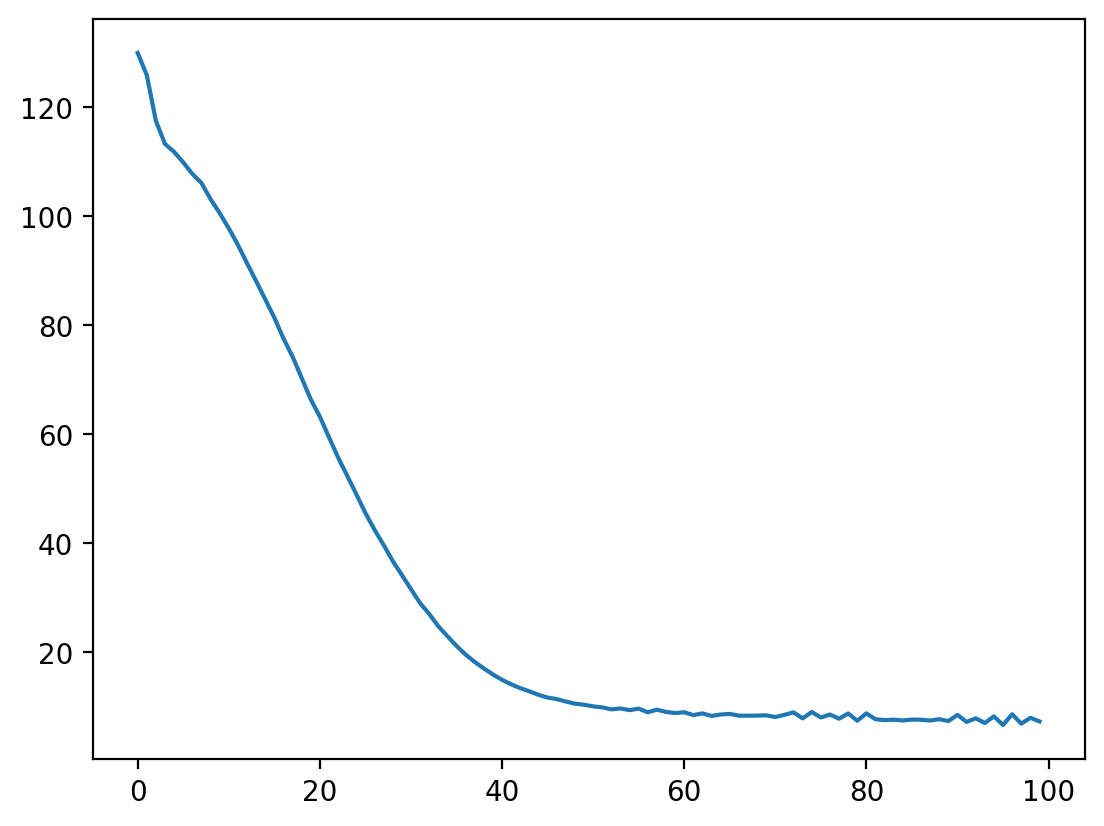

In [16]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

## Generating Music

In [17]:
def music_inference_model(LSTM_cell, densor, Ty=100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.

    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate

    Returns:
    inference_model -- Keras model instance
    """

    n_values = densor.units
    n_a = LSTM_cell.units
    x0 = Input(shape=(1, n_values))
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0
    outputs = []
    for t in range(Ty):
      _, a, c = LSTM_cell(inputs=x, initial_state=[a, c])
      out = densor(a)
      outputs.append(out)
      x = tf.math.argmax(out, axis=-1)
      x = tf.one_hot(x, depth=n_values)
      x = RepeatVector(1)(x)
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    return inference_model

In [18]:
inference_model = music_inference_model(LSTM_cell, densor, Ty = 50)

In [19]:
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 90)]      0           []                               
                                                                                                  
 a0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 c0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         39680       ['input_2[0][0]',                
                                 (None, 64),                      'a0[0][0]',               

In [20]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [21]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer,
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.

    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 90), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel

    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """

    n_values = x_initializer.shape[2]
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    indices = np.argmax(pred, axis = -1)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    return results, indices

In [22]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
1/1 [==============================] - 17s 17s/step
Generated 33 sounds using the predicted values for the set of chords ("1") and after pruning
1/1 [==============================] - 0s 49ms/step
Generated 33 sounds using the predicted values for the set of chords ("2") and after pruning
1/1 [==============================] - 0s 49ms/step
Generated 33 sounds using the predicted values for the set of chords ("3") and after pruning
1/1 [==============================] - 0s 49ms/step
Generated 33 sounds using the predicted values for the set of chords ("4") and after pruning
1/1 [==============================] - 0s 47ms/step
Generated 33 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


In [23]:
mid2wav('output/my_music.midi')
IPython.display.Audio('./output/rendered.wav')